# Estimating $a$ from spiral tip trajectories
Tim Tyree<br>
9.5.2023

In [571]:
import sys,os
og_stdout=sys.stdout
from lib.my_initialization import *

In [572]:
os.chdir(nb_dir)
from lib import *

In [573]:
import cupy, cudf
from lib.rapids_func import *

In [574]:
import seaborn as sns
import matplotlib.ticker as mtick
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

In [575]:
import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# define module

In [658]:
1

1

# dev
- step 1: reproduce known value for $a$
- step 2: compute $a$ for new folder of tip trajectories. did $a$ change?

In [724]:
# min_duration=40
# min_duration=20
# min_duration=10
min_duration=1.
DS=5./200.
width=200
height=200
tmin=100
# DT=1. #ms/frame
# width=200.  #pixels
# height=200. #pixels
# tavg1=0.  #moving average window, in ms
# tavg2=14., #ms #savgol_filter time window performed on R  #12 ms was no longer smooth
min_termination_time=100.
min_duration_thresh=1. #ms #minimum lifetime for a spiral tip position to be considered
max_Rfinal_thresh=0.5  #cm
max_dtmax_thresh= 0.   #cm # max disagreement between tmax for _self relative to _other
round_t_to_n_digits=7
t_col='t'
pid_col='particle'
trial_col='trial_num'
use_tavg2=True #unsmoothed R is preserved through R_nosavgol
testing=True
printing=True#,**kwargs):
use_flip_tdeath=False  #True could need implementing
minlifetime=40.#ms
Rcol='R_nosavgol'
taucol='tdeath'
# pid_mate='pid_birthmate'
# r_mate='r0'
pid_mate='pid_deathmate'
r_mate='rT'
minr=1.5 #cm
minr=0.25 #cm
# minr=0.2 #cm
# minr=0.3
minr=0.35
# minr=0.5 #cm
minr=1 #cm  #heretim
# jump_thresh=.3
# jump_thresh=.5
jump_thresh=20
# jump_thresh=3 #<<<expect this to increase apparent $a$
# np.diff(R_values).max<jump_thresh
# x_values=
# jump_index_array, spd_lst = find_jumps(x_values,y_values,width=width,height=height, DS=DS,DT=DT, jump_thresh=None)

In [753]:
input_folder= f"{nb_dir}/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/trajectories"  #2 min run time
# input_folder= f"{nb_dir}/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_30_Ko_5.4_diffCoef_0.001/trajectories"

input_fn_lst = os.listdir(input_folder)
#TODO(later): remove .DS_Store on mac explicitely
task_lst=[]
for trial_num,input_fn in enumerate(input_fn_lst):
    input_dir=os.path.join(input_folder,input_fn)
    task=input_dir,trial_num
    task_lst.append(task)
len(task_lst)

157

In [754]:
def routine(task):
    input_dir,trial_num=task
    df_traj=pd.read_csv(input_dir)
    df_interactions=compute_df_interactions(input_dir,DS=DS,width=width,height=height,tmin=tmin,pid_col='particle',t_col='t',
                                            min_duration=min_duration)#,**kwargs)
    l=list (df_traj.groupby(t_col).groups.keys())
    DT=np.around(l[1]-l[0],round_t_to_n_digits)
    # df_R_lst=[]
    # boo = (df_interactions[['rT']].values*DS<minr).flatten()
    boo = (df_interactions[[r_mate]].values*DS<minr).flatten()
    # boo = (df_interactions[['r0']].values*DS<minr).flatten()
    df_R_lst=[]
    for i,row in df_interactions.loc[boo].iterrows():
        pid1=int(row['pid'])
        pid2=int(row['pid_deathmate'])
        d=df_traj[df_traj['particle']==pid1]\
            .set_index('frame')[['x','y']]\
            .rename(columns={'x':'x_self','y':'y_self'})
        d2=df_traj[df_traj['particle']==pid2]\
            .set_index('frame')[['x','y']]
        d['x_other']=d2['x']
        d['y_other']=d2['y']
        #compute the three options for the square distance with pbc
        d['sdx']=(d['x_self']-d['x_other'])**2
        d['sdxp']=(d['x_self']-d['x_other']+width)**2
        d['sdxm']=(d['x_self']-d['x_other']-width)**2
        d['sdy']=(d['y_self']-d['y_other'])**2
        d['sdyp']=(d['y_self']-d['y_other']+height)**2
        d['sdym']=(d['y_self']-d['y_other']-height)**2
        #choose the minimum of each class of option
        d['minsdx']=d[['sdx','sdxp','sdxm']].min(axis=1)
        d['minsdy']=d[['sdy','sdyp','sdym']].min(axis=1)
        d['dist']=np.sqrt(d['minsdx'] + d['minsdy'])
        # d['dist']=(d['minsdx'] + d['minsdy'])**0.5
        d['R']=d['dist']*DS

        use_reverse_time=True
        R_values=d['R'].values
        if use_reverse_time:
            R_values = np.array(list(reversed(R_values)))
        N=R_values.shape[0]
        tdeath_values=np.arange(0,DT*N,DT)
    #     tdeath_values.shape,R_values.shape
        #TODO(later): optionally, later, if needed align R timeseries
        df_R=pd.DataFrame({'R':R_values,
                           'tdeath':tdeath_values,
                           'pid1':pid1,
                           'pid2':pid2,
                          })
        df_R['trial_num']=trial_num
        #record if no jumps
        if np.abs(np.diff(R_values)).max()<jump_thresh:
            #record
            df_R_lst.append(df_R)
    if len(df_R_lst)>0:
        df_R = pd.concat(df_R_lst)
        return df_R
    else:
        return None

In [755]:
ncores=os.cpu_count()-1
df_R_lst = eval_routine_multiprocess(routine, task_lst, ncores)
df_R = pd.concat(df_R_lst)

In [757]:
# df_R.plot(kind='scatter',x='tdeath',y='R',c='pid1',cmap='tab20',alpha=0.5)
# plt.show()

In [730]:
#DONE: aggregate over many trials
# beep(3)

In [756]:
R_dir=input_folder.replace('/trajectories','/annihilation_ranges.csv')
df_R.to_csv(R_dir,index=False)
print(f"{R_dir=}")

R_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/annihilation_ranges.csv'


In [732]:
beep(3)



0

In [733]:
# R_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/annihilation_ranges.csv'
# R_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_30_Ko_5.4_diffCoef_0.001/annihilation_ranges.csv'

In [704]:
# input_fn = f"{nb_dir}/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.0005/"
# input_fn = f"{nb_dir}/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/trajectories/ic001.11_traj_sr_600_mem_0.csv"
# input_fn = f"{nb_dir}/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.001/trajectories/ic001.11_traj_sr_600_mem_0.csv"
# param_qu_tmax_30_Ko_3.8_diffCoef_0.0005/
#DONE: load ^that
#DONE: compute df_R
#TODO: compute df_msr, as before
#TODO: plot msr versus t'
#TODO: compute $a$, as before

In [705]:
# for i,row in df_interactions.iterrows():
#     if minr>=DS*row[r_mate]:
#         pid1 = int(row['pid'])
#         pid2 = int(row[pid_mate])
# #         pid_mate = row[pid_mate]
#         #DONE: measure the range vs. time of pid1,2 for annihilation event
#         #TODO: measure the range vs. time of pid1,2 for creation event

# scratchwerk

In [668]:
# df=cudf.DataFrame(df_traj)
# df['trial_num']=-1
# # df['index']=df.index.values
# df['index']=df.reset_index().index.values
# # df.set_index(['trial_num','particle','frame'],inplace=True)
# # df.set_index(['frame'],inplace=True)
# # df

In [669]:

# dfr, df_pairs = compute_radial_velocities_of_annihilations_cu(df,#.set_index(['trial_num','pid_self']),#.reset_index(),
#         navg2=0, #num. frames to average over.  navg2 must be an odd, positive integer.
#         DS=DS,    #cm/pixel
#         DT=DT,   #ms/frame
#         width=width,
#         height=height,
#         max_dtmax_thresh=max_dtmax_thresh,  #ms
#         max_Rfinal_thresh=max_Rfinal_thresh,  #cm
#         min_duration_thresh=min_duration_thresh,  #ms
#         use_tavg2=use_tavg2,
#         pid_col=pid_col,
#         trial_col=trial_col,
#         use_dask=False,
#         printing=printing,
#         testing=False)#testing)
# dfr.reset_index(inplace=True)
# # dfr.head()

# if use_flip_tdeath:
#     pass
#     #dfr['tdeath']=??
# #TODO(later): implememnt ^that

# df_R_lst=[]
# for (trial_num,pid_self,pid_other),g in dfr.groupby(by=['trial_num','pid_self','pid_other']):
#     lifetime=g.shape[0]*DT
#     if lifetime>=minlifetime:
#         df_R_lst.append(g.sort_values(by=taucol)[['trial_num','pid_self','pid_other',taucol,Rcol]].to_pandas())
# #         print(f"{trial_num,pid_self,pid_other}")
# df_R = pd.concat(df_R_lst)
# # df_R_lst
# df_R.head()

In [670]:
#TODO: collect over all trials
#TODO: average the first 40 ms
#TODO: fit and measure $a$, as before

In [671]:
# dfr
# g.sort_values(by=taucol)[['trial_num','pid_self','pid_other',taucol,Rcol]].to_pandas()

# TODO: avg over repeated observations, as before

In [758]:
R_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/annihilation_ranges.csv'
# R_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_30_Ko_5.4_diffCoef_0.001/annihilation_ranges.csv'
# R_dir='/Users/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/annihilation_ranges.csv'
# R_dir='/Users/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_30_Ko_5.4_diffCoef_0.001/annihilation_ranges.csv'

In [759]:
df_r = pd.read_csv(R_dir)

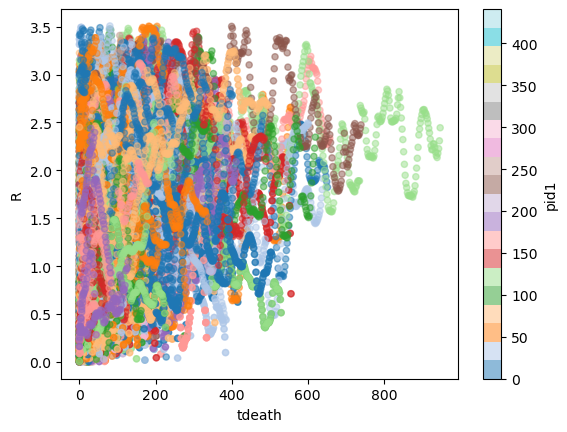

In [760]:
df_r.plot(kind='scatter',x='tdeath',y='R',c='pid1',cmap='tab20',alpha=0.5)
plt.show()

In [761]:
#TODO: subtract zero from each trajectory
#Q: was ^this done before or after averaging?

In [762]:
##########################
# GOAL: Compute MSR(t')
##########################
# R_col='R_nosavgol'
# T_col='tdeath_align'
R_col='R'
T_col='tdeath'
use_subtract_zero=True
use_subtract_zero=False
SR_values_lst=[]
tau_values_lst=[]
count_events=0
# for dict_msr in dict_msr_lst:
#     #recall the data values
#     df_R=dict_msr['df_R']
# for trial_num,df_R in df_r.groupby(by='trial_num'):
# for trial_num,df_R in df_r.groupby(by='trial_num'):
for trial_num,df_R in df_r.groupby(by=['trial_num','pid1']):
    SR_values=df_R[R_col].values**2
    tau_values=df_R[T_col].values
    if use_subtract_zero:
        SR_values-=SR_values[0]



    #count the number of events
#     num_events=df_R['index_pairs'].drop_duplicates().values.shape[0]
#     num_events=df_R['annihilation_index'].drop_duplicates().values.shape[0]

    #remove any null values
    boo_nan=np.isnan(tau_values)#tdeath_align has 6/1700 data points as null
    boo_nan|=np.isnan(SR_values)
    SR_values=SR_values[~boo_nan].copy()
    tau_values=tau_values[~boo_nan].copy()

    #record
    SR_values_lst.append(SR_values)
    tau_values_lst.append(tau_values)
#     count_events+=num_events
SR_values=np.concatenate(SR_values_lst)
tau_values=np.concatenate(tau_values_lst) 
    
num_trials=len(SR_values_lst)
num_obs=SR_values.shape[0]
# print(f"aggregated N''={num_obs} R(t') observations from N'={num_trials} termination events. this involved N={count_events} pair-annihilation events.")
# num_trials,len(tau_values_lst),num_obs,tau_values.shape[0] #they're the same

In [763]:
#DONE: investigate which parameter setting needs to be changed to make df_smoothed mapping to dfr have dfr with {num_particles/2=}, {num_pairs=}
#DONE: wrap up to here into 1-3 functions for a dask.bag routine
#DONE: wrap routine as func foo
#DONE: eval_routine
#DONE: plot the MSR, as before
#heretimheretim



# if printing:
#     print(f"removed {sum(boo_nan)} data points due to having null x-value (or y-value)") #~6 per 1700 removed bc of alignment of time
assert not np.isnan(SR_values).any() and not np.isnan(tau_values).any()
SR_values.shape,tau_values.shape
x_values_in = tau_values
y_values_in = SR_values
# np.max(tau_values),
tmax=np.max(x_values_in)

#compute bootstrap 
x_values_in=tau_values
y_values_in=SR_values
# bins='auto'
# bins=np.arange(0,200,1)
bins=np.arange(0,tmax,1)
df_bootstrap=bin_and_bootstrap_xy_values_parallel(x_values_in,
                               y_values_in,#dict_msr_lst,
                               xlabel='tdeath_avg',
                               ylabel='MSR',
                               bins=bins,
                               min_numobs=None,
                               num_bootstrap_samples=1000,
                               npartitions=10,
                               use_test=False)
df_bootstrap.head()

,tdeath_avg,MSR,Delta_tdeath_avg,Delta_MSR,p_tdeath_avg,p_MSR,counts
0,0.0,0.225496,0.0,0.017133,0.0,0.050334,10329
1,2.0,0.345844,0.0,0.017359,0.0,0.866971,10329
2,4.0,0.424625,0.0,0.018551,0.0,0.721206,9699
3,6.0,0.495891,0.0,0.018233,0.0,0.675621,9274
4,8.0,0.565309,0.0,0.019825,0.0,0.020062,8928


In [764]:
x_values=df_bootstrap['tdeath_avg'].values
y_values=df_bootstrap['MSR'].values
yerr_values=df_bootstrap['Delta_MSR'].values
x_values.shape,y_values.shape,yerr_values.shape

((244,), (244,), (244,))

Does this appear to intersect at zero?


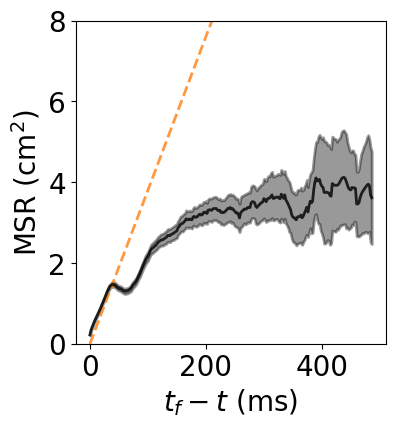

In [765]:
print(f"Does this appear to intersect at zero?")
c='k'
# plt.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
# plt.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
# format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
# # plt.xlim([0,180])
# # plt.ylim([0,3.1])
# plt.xlim([0,15])
# plt.ylim([-.1,1])
# plt.show()

# #plot expected
# plt.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
# # plt.plot(x_values,4*1.8*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
# #plot data
# plt.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
# plt.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
# format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
# plt.xlim([0,180])
# plt.ylim([0,4.1])
# plt.show()

#plot expected
fig,ax=plt.subplots(figsize=(4,4.2))
ax.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
# ax.plot(x_values,4*1.8*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
#plot data
ax.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
ax.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=ax,xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
# ax.set_xlim([0,250])
ax.set_ylim([0,8])
plt.show()

In [766]:
#TODO: measure $a$
#Q: does Ko=5.4 reproduce what we already have?
#TODO: repeat for other Ko parameter setting
#Q: is there an effect?

In [767]:
# select msr from the full models for fitting
min_tdeath=100. #ms  #LR
# min_tdeath=102. #ms  #LR
# min_tdeath=300. #ms  #FK 
# min_tdeath=600. #ms  #FK 
# max_tdeath=1500. #ms  #FK 
max_tdeath=1500. #ms  #FK 
# max_tdeath=250. #ms  #FK 
printing=True

boo=x_values>=min_tdeath
boo&=x_values<max_tdeath
t_values=x_values[boo].copy()*1e-3
msr_values=y_values[boo].copy() 
# msr_values-= np.min(msr_values)
msr_values-=msr_values[0]
#measure D
dict_output = compute_95CI_ols(x=t_values,y=msr_values)
D = dict_output['m']/8
Delta_D = dict_output['Delta_m']/8

In [768]:
np.min(t_values)
t_values

array([0.1  , 0.102, 0.104, 0.106, 0.108, 0.11 , 0.112, 0.114, 0.116,
       0.118, 0.12 , 0.122, 0.124, 0.126, 0.128, 0.13 , 0.132, 0.134,
       0.136, 0.138, 0.14 , 0.142, 0.144, 0.146, 0.148, 0.15 , 0.152,
       0.154, 0.156, 0.158, 0.16 , 0.162, 0.164, 0.166, 0.168, 0.17 ,
       0.172, 0.174, 0.176, 0.178, 0.18 , 0.182, 0.184, 0.186, 0.188,
       0.19 , 0.192, 0.194, 0.196, 0.198, 0.2  , 0.202, 0.204, 0.206,
       0.208, 0.21 , 0.212, 0.214, 0.216, 0.218, 0.22 , 0.222, 0.224,
       0.226, 0.228, 0.23 , 0.232, 0.234, 0.236, 0.238, 0.24 , 0.242,
       0.244, 0.246, 0.248, 0.25 , 0.252, 0.254, 0.256, 0.258, 0.26 ,
       0.262, 0.264, 0.266, 0.268, 0.27 , 0.272, 0.274, 0.276, 0.278,
       0.28 , 0.282, 0.284, 0.286, 0.288, 0.29 , 0.292, 0.294, 0.296,
       0.298, 0.3  , 0.302, 0.304, 0.306, 0.308, 0.31 , 0.312, 0.314,
       0.316, 0.318, 0.32 , 0.322, 0.324, 0.326, 0.328, 0.33 , 0.332,
       0.334, 0.336, 0.338, 0.34 , 0.342, 0.344, 0.346, 0.348, 0.35 ,
       0.352, 0.354,

In [769]:
# msr_values

In [770]:
if printing:
    print(f"- D = m/8 = {D:.4f} +/- {Delta_D:.4f} (annihilation fit to t'>{min_tdeath:.4f} ms, t'<{max_tdeath:.4f})")
#     print(f"- D = m/8 = {Dc:.4f} +/- {Delta_Dc:.4f} (creation fit to t'<{min_tdeath:.4f} ms)")
#     print(f"- D = m/8 = {D:.4f} +/- {Delta_D:.4f} (annihilation fit to t'<{min_tdeath:.4f} ms)")
#     print_dict(dict_output)
# - D = m/8 = 0.3919 +/- 0.2262 (annihilation fit to t'<100.0000 ms) #by trial
# - D = m/8 = 0.1525 +/- 0.2036 (annihilation fit to t'<100.0000 ms)  #by trial,pid1
# - D = m/8 = -0.0205 +/- 0.2155 (annihilation fit to t'<100.0000 ms) #by trial,pid1, no ysubtract 
# - D = m/8 = -0.0205 +/- 0.2155 (annihilation fit to t'<100.0000 ms) #by trial, no ysubtract
# - D = m/8 = 1.2639 +/- 0.1688 (annihilation fit to t'>100.0000 ms, t'<250.0000) #by trial, no ysubtract
# - D = m/8 = 1.2639 +/- 0.1688 (annihilation fit to t'>100.0000 ms, t'<250.0000)

- D = m/8 = 0.4158 +/- 0.0348 (annihilation fit to t'>100.0000 ms, t'<1500.0000)


In [771]:
minlifetime_values_lr = df_r.groupby(by=['trial_num','pid1'])['tdeath'].max().values
num_termination_events_lr = df_r['trial_num'].drop_duplicates().shape[0]
# minlifetime_values_lr = df_ranges_lr.groupby(by=['trial_num','annihilation_index'])['tdeath'].max().values
meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values_lr)
printing=True
if printing:
    print(f" - LR: mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) from {num_termination_events_lr} termination events")

minlifetime_values =minlifetime_values_lr

 - LR: mean lifetime: 45.9363 +/- 1.1792 ms (N=10329, p_normal: 0.2586) from 157 termination events


In [772]:
# meanx=33.4

In [773]:
meanx

45.93629586600833

In [774]:
#### 
print(f"\ncomputing simulated annealing fits of oscillatory particle model to the Luo-Rudy model...")
# select msr from the full models for fitting
# x_values=x_values_lr.copy()
# y_values=y_values_lr.copy()
# minlifetime_values=minlifetime_values_lr.copy()
# max_tdeath=100. #ms #for lr
max_tdeath=100. #ms #for lr
# max_tdeath=300. #ms #for fk
# meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values)
Gamma=float(meanx)
# testing=False 
# testing=True # True adds ~60 - 6.27 seconds to runtime
# if printing:
#     print(f"mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) from {minlifetime_values.shape[0]} observations")
#fit using simulated annealing
a0,a1,period,phase,rmse = fit_msr_oscillatory(x_values,y_values,max_tdeath,
                                    D=0.,maxiter=int(10000/4),seed=42,printing=printing)
alinear = comp_alinear(a0,a1,period,Gamma,phase)
omega = 2*np.pi/period
z = Gamma*omega
print(f"\tattraction coefficient: {a0=:.4f}, {a1=:.4f}, {z=:.4f}, {phase=:.4f} --> {alinear=:.4f} cm^2/s")
dict_fit=dict(a0=a0,a1=a1,period=period,phase=phase,rmse=rmse,
              alinear=alinear,omega=omega,z=z,Gamma=Gamma, Delta_Gamma=Delta_meanx, num_obs=num_obsx, p_normal=p_normalx)
if not testing:
    print_dict(dict_fit)

if testing:
    print(f"performing fit using simulated annealing with 10X the number of learning rounds...")
    a0,a1,period,phase,rmse = fit_msr_oscillatory(x_values,y_values,max_tdeath,
                                        D=0.,maxiter=10000,#maxiter=100000, 
                                                  seed=43,printing=printing)
    alinear = comp_alinear(a0,a1,period,Gamma,phase)
    omega = 2*np.pi/period
    z = Gamma*omega
    print(f"\tattraction coefficient: {a0=:.4f}, {a1=:.4f}, {z=:.4f}, {phase=:.4f} --> {alinear=:.4f} cm^2/s")
    dict_fit=dict(a0=a0,a1=a1,period=period,phase=phase,rmse=rmse,
                  alinear=alinear,omega=omega,z=z,Gamma=Gamma, Delta_Gamma=Delta_meanx, num_obs=num_obsx, p_normal=p_normalx)
    print_dict(dict_fit)    

dict_osc_fit_lr=dict(dict_fit)


computing simulated annealing fits of oscillatory particle model to the Luo-Rudy model...
performing simulated annealing with D=0 fixed (num. epochs: 2500)...
simulated annealing fit: a0=4.4045, a1=5.7877, period=87.0236, phase=-0.7213 --> rmse=0.0368 cm^2
	attraction coefficient: a0=4.4045, a1=5.7877, z=3.3166, phase=-0.7213 --> alinear=5.8230 cm^2/s
performing fit using simulated annealing with 10X the number of learning rounds...
performing simulated annealing with D=0 fixed (num. epochs: 10000)...
simulated annealing fit: a0=4.1932, a1=5.9593, period=82.4087, phase=-0.9490 --> rmse=0.0353 cm^2
	attraction coefficient: a0=4.1932, a1=5.9593, z=3.5024, phase=-0.9490 --> alinear=5.7337 cm^2/s
a0=4.193237476668017
a1=5.95926128974385
period=82.40871013776672
phase=-0.948990983451973
rmse=0.03526206103381962
alinear=5.733665157040891
omega=0.07624418943914635
z=3.5023756441406144
Gamma=45.93629586600833
Delta_Gamma=1.1792186457522862
num_obs=10329
p_normal=0.25856271572824185


In [775]:
(5.4-3.8)/5.4
# alinear=8.8211 cm^2/s,  alinear=10.5204 cm^2/s #K0=5.4 #mean lifetime: 81.7227 +/- 2.8652 ms #D = m/8 = 0.1262 +/- 0.2053
# alinear=5.3581 cm^2/s,  alinear=6.4220 cm^2/s #K0=3.8 #mean lifetime: 100.8040 +/- 2.8937 ms #D = m/8 = 0.3011 +/- 0.0429
#heretim
# alinear=9.2551, alinear=9.3359 cm^2/s #K0=5.4 #mean lifetime: 39.3010 +/- 1.2365 ms, D = m/8 = 0.7724 +/- 0.1682
# alinear=5.8230 cm^2/s, alinear=5.7337 cm^2/s #mean lifetime: 45.9363 +/- 1.1792 ms, D = m/8 = 0.4158 +/- 0.0348

0.2962962962962964

In [778]:
(10.5204-6.4220)/10.5204
# (9.5600-??)/9.5600 
(9.3359-5.7337)/9.3359

0.38584389292944443

- At first glance, reducing $[K^+]_o$ by 29.6% reduced $a$ by 39.0%. ( min_duration=40)
- Using same $a$ as in table 1, For the LR model, reducing $[K^+]_o$ by 29.6% reduced $a$ by 38.6%. ( min_duration=1)

In [779]:
alinear+2*D

6.565356598938359

In [780]:
9.3+2*0.42

10.14